In [15]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

Torch version: 2.5.1+cu121
CUDA version: 12.1
Is CUDA available: True


In [7]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

Train Test Split

In [9]:
train_split  = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [13]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
    #plots training data, test data, and predictions 
    plt.figure(figsize=(10, 7))
    #plot training data in blue
    plt.scatter(train_data, train_labels, c= 'b', s =4, label = "Training Data")
    #plot test data in blue
    plt.scatter(test_data, test_labels, c= 'g', s =4, label = "Test Data")
    
    #plot predicitions if it exist
    if predictions is not None:
        plt.scatter(test_data, predictions, c= 'r', s =4, label = "Predictions")
    
    #show legend
    plt.legend(prop ={"size": 14})

Build Model

In [17]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad= True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad= True, dtype=torch.float))
    #foward method
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias 

torch.nn - contains all of the buildings for computational graph \
troch.nn.parameter - what parameters should our model try to learn \
troch.nn.Module - base class for all nueral network modules, you subclass to overwrite forward() \
torch.optim - optimizers



In [39]:
torch.manual_seed(42)
model0 = LinearRegressionModel()
model0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [40]:
#make predictions 
#inference mode -> don't track gradients 
with torch.inference_mode():
    y_preds = model0(X_test)
"""
with torch.no_grad():
"""
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [41]:
#setup Loss func
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model0.parameters(), lr = 1e-2)


In [ ]:
#building a training loop
epochs = 200

epoch_count = []
loss_val = []
test_loss_val = []

for epoch in range(epochs):
    #set model on training mode 
    model0.train() #train model
    
    #1. forward pass
    y_pred = model0(X_train)
    
    #2. calc loss
    loss = loss_fn(y_pred, y_train)
    
    #3 #clears previous gradients
    optimizer.zero_grad()
    
    #backpropagation
    loss.backward()
    
    #step the optimizer (update model parameters based on gradients) 
    optimizer.step()
    
    #testing
    model0.eval() #turn off gradient tracking (dropout, batch normalization)
    with torch.inference_mode():
        #foward pass
        test_pred = model0(X_test)
        
        #calc loss 
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_val.append(loss)
        test_loss_val.append(test_loss)
        print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}')
    

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test Loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test Loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test Loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test Loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test Loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test Loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test Loss: 0.03233227878808975
Ep

In [43]:
model0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

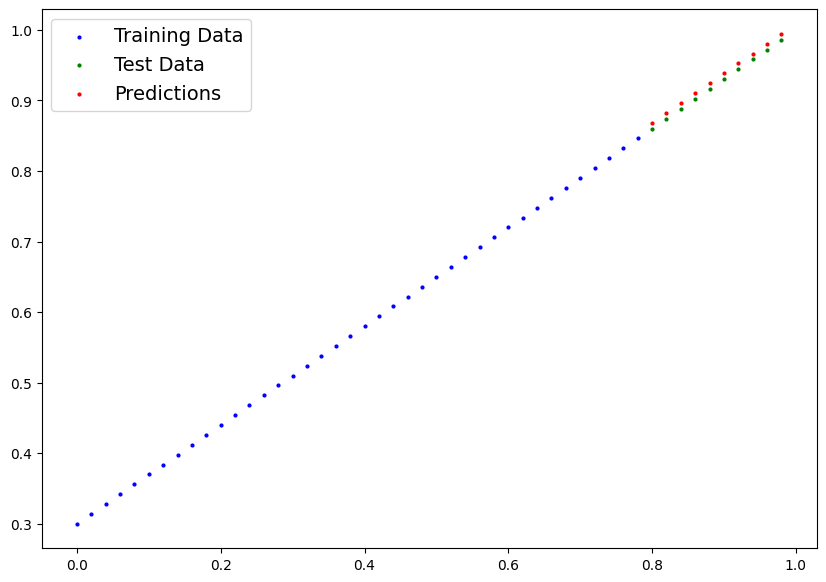

In [44]:

plot_predictions(predictions=test_pred)

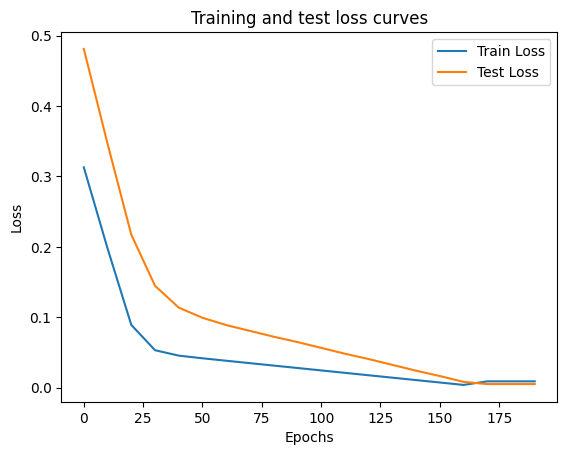

In [45]:
plt.plot(epoch_count, np.array(torch.tensor(loss_val).numpy()), label= "Train Loss")
plt.plot(epoch_count, test_loss_val, label= "Test Loss")
plt.title("Training and test loss curves")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

Saving Model

In [47]:
#saving our model
from pathlib import Path
#create directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#SAVE MODEL 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model0.state_dict(), f= MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


Loading Model

In [48]:
#to load, we have to instantiate a new instance of our model class
loaded_model0 = LinearRegressionModel()
#load the saved state_dict of model0 (this will update the new instance with updated parameters)
loaded_model0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

C:\Users\danie\AppData\Local\Temp\ipykernel_12432\3390426207.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>